Dataset Description:
Features shape: (569, 30)
Target distribution:
1    357
0    212
Name: count, dtype: int64
Malignant (0): 212 samples
Benign (1): 357 samples

Evaluation with Default Threshold (0.5):
--------------------------------------------------
Confusion Matrix:
[[ 62   1]
 [  2 106]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

ROC-AUC Score: 0.9979


/tmp/ipython-input-1-397012415.py:68: RuntimeWarning: invalid value encountered in scalar divide
  precision_1 = tp / (tp + fp)



Evaluation with Tuned Threshold (0.1717):
--------------------------------------------------
Confusion Matrix:
[[ 60   3]
 [  0 108]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        63
           1       0.97      1.00      0.99       108

    accuracy                           0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



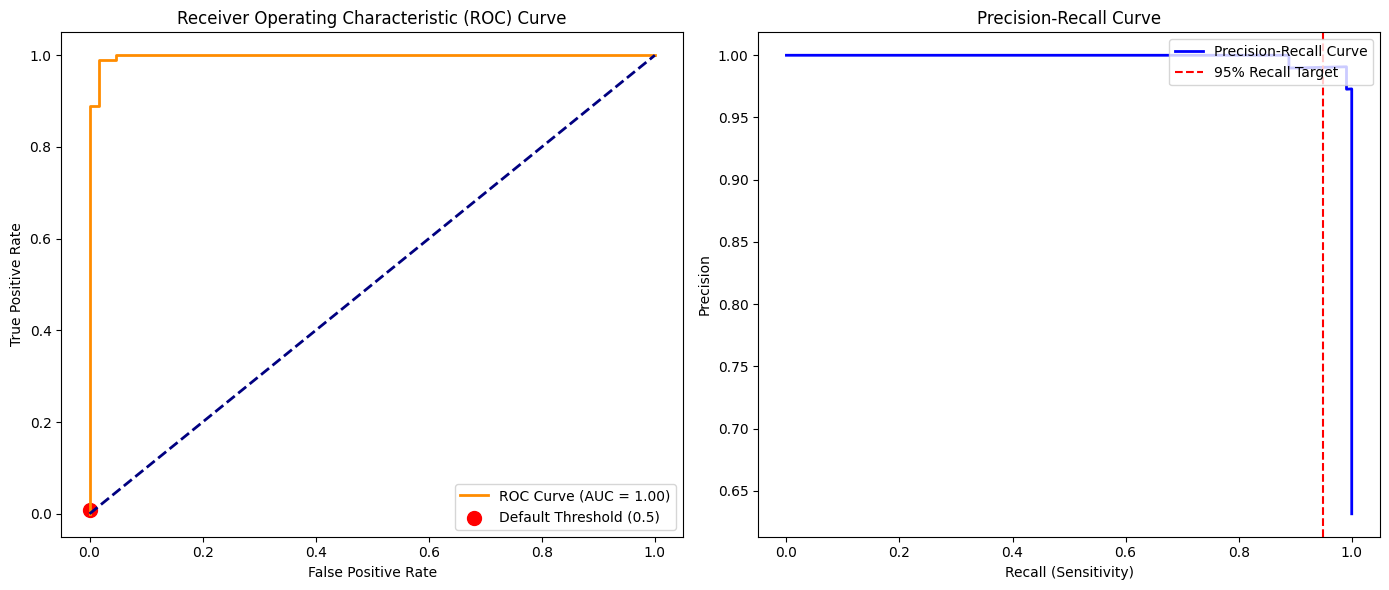


Key Concepts Explanation:
--------------------------------------------------
1. Sigmoid Function:
   - Logistic regression uses the sigmoid function to convert linear
     combinations of features into probabilities between 0 and 1.
   - Formula: P(y=1) = 1 / (1 + e^(-z)) where z = w·x + b
   - This outputs the probability that a sample belongs to class 1

2. Threshold Tuning:
   - Default classification threshold = 0.5
   - In medical diagnosis, false negatives (missing cancer) are
     more dangerous than false positives
   - We lowered the threshold to 0.1717 to prioritize
     identifying malignant cases (class 0), reducing false negatives
   - Tradeoff: Increased false positives but improved recall for malignant cases


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve
)

np.random.seed(42)

# Load dataset
cancer_data = load_breast_cancer()
X = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y = pd.Series(cancer_data.target)

# Dataset information
print("="*50)
print("Dataset Description:")
print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Malignant (0): {sum(y==0)} samples")
print(f"Benign (1): {sum(y==1)} samples")
print("="*50)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Making predictions with default threshold (0.5)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probability of class 1 (benign)
y_pred = (y_proba >= 0.5).astype(int)

# Evaluating model performance
print("\nEvaluation with Default Threshold (0.5):")
print("-"*50)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Calculating ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Threshold tuning for better recall (reducing false negatives)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Calculating metrics for different thresholds
def evaluate_threshold(threshold):
    y_pred_tuned = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tuned).ravel()
    recall_0 = tn / (tn + fp)  # Recall for class 0 (malignant)
    recall_1 = tp / (tp + fn)  # Recall for class 1 (benign)
    precision_1 = tp / (tp + fp)
    return recall_0, recall_1, precision_1

# Find threshold that maximizes recall for malignant class (class 0)
thresholds = np.linspace(0, 1, 100)
recalls_0 = []
recalls_1 = []
precisions_1 = []

for thresh in thresholds:
    r0, r1, p1 = evaluate_threshold(thresh)
    recalls_0.append(r0)
    recalls_1.append(r1)
    precisions_1.append(p1)

# Find threshold that gives at least 95% recall for malignant (class 0)
target_recall_0 = 0.95
viable_thresholds = [thresh for i, thresh in enumerate(thresholds) if recalls_0[i] >= target_recall_0]

if viable_thresholds:
    chosen_threshold = min(viable_thresholds)  # Choose the least strict threshold
else:
    chosen_threshold = 0.5  # Fallback to default

# Make predictions with tuned threshold
y_pred_tuned = (y_proba >= chosen_threshold).astype(int)

# Evaluate tuned model
print("\n" + "="*50)
print(f"Evaluation with Tuned Threshold ({chosen_threshold:.4f}):")
print("-"*50)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned))

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

# Generate Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)

# Create visualizations
plt.figure(figsize=(14, 6))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[1], tpr[1], color='red', s=100, label=f'Default Threshold (0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.axvline(x=0.95, color='red', linestyle='--', label='95% Recall Target')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Explain sigmoid function and threshold tuning
print("\n" + "="*50)
print("Key Concepts Explanation:")
print("-"*50)
print("1. Sigmoid Function:")
print("   - Logistic regression uses the sigmoid function to convert linear")
print("     combinations of features into probabilities between 0 and 1.")
print("   - Formula: P(y=1) = 1 / (1 + e^(-z)) where z = w·x + b")
print("   - This outputs the probability that a sample belongs to class 1")
print("\n2. Threshold Tuning:")
print("   - Default classification threshold = 0.5")
print("   - In medical diagnosis, false negatives (missing cancer) are")
print("     more dangerous than false positives")
print(f"   - We lowered the threshold to {chosen_threshold:.4f} to prioritize")
print("     identifying malignant cases (class 0), reducing false negatives")
print("   - Tradeoff: Increased false positives but improved recall for malignant cases")